In [23]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor_model import Actor
from copy import deepcopy

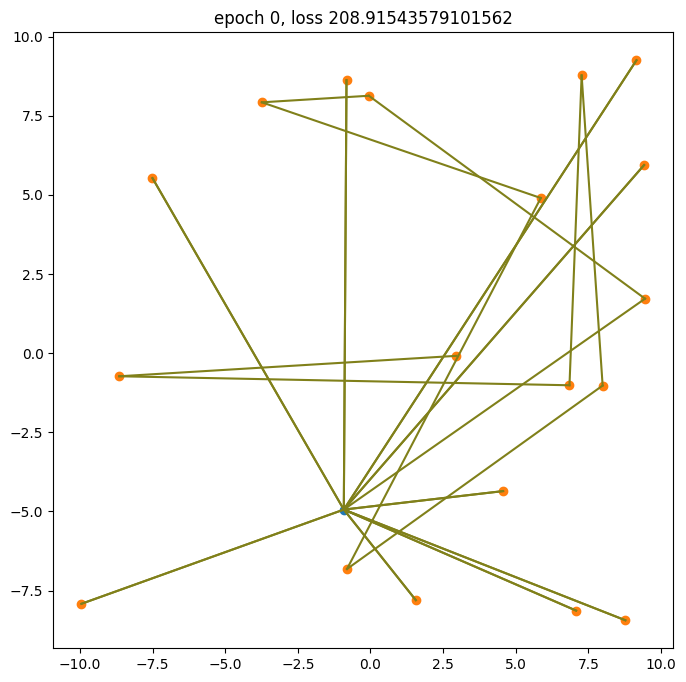

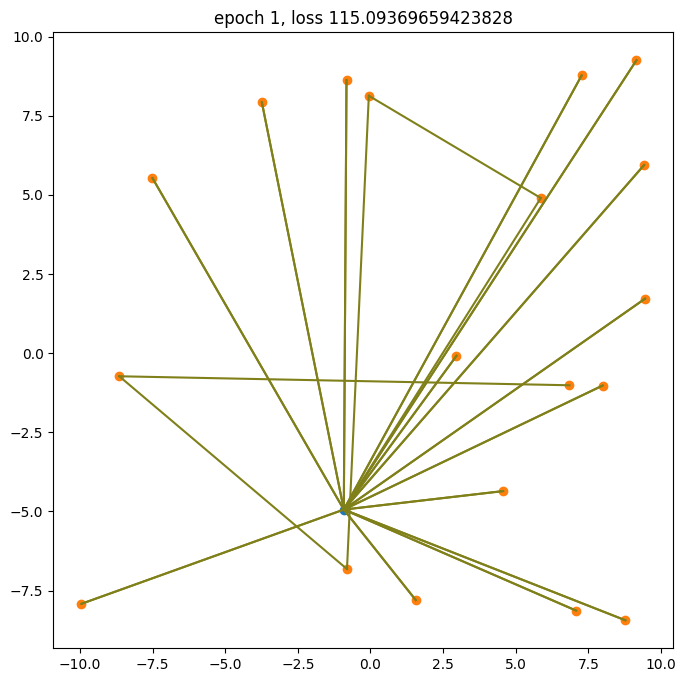

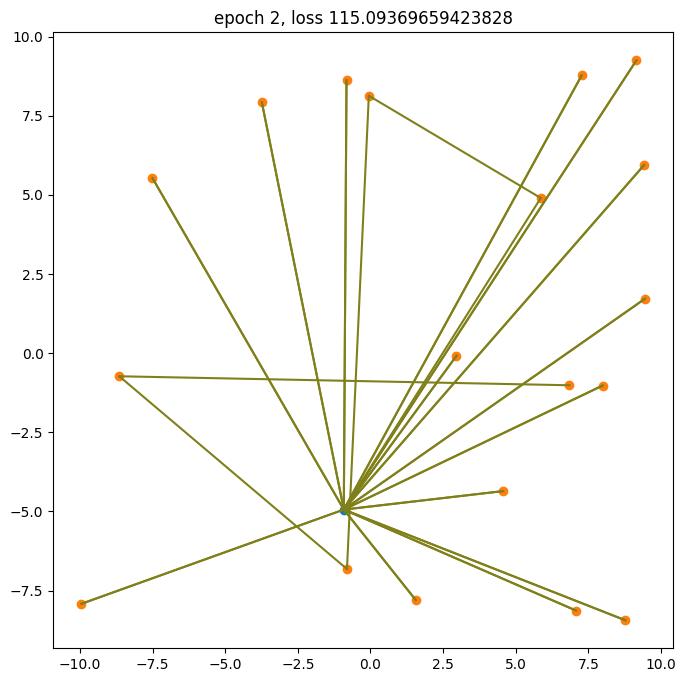

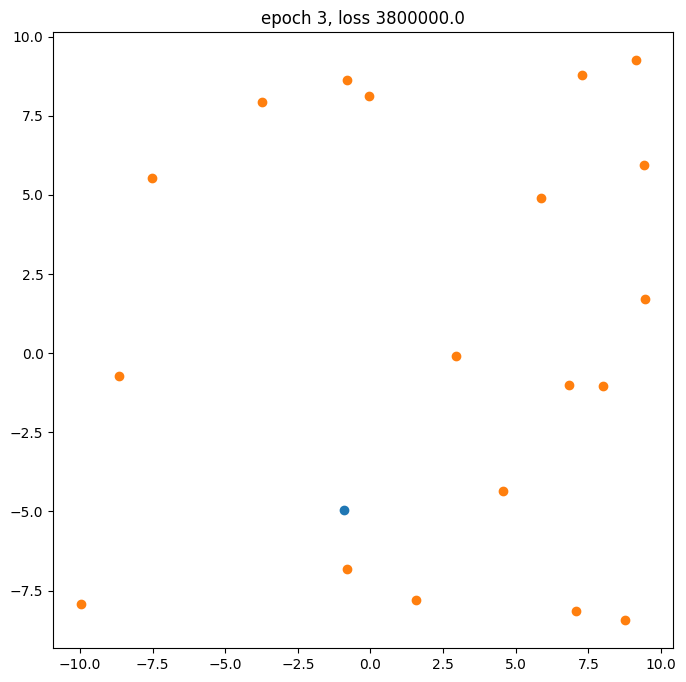

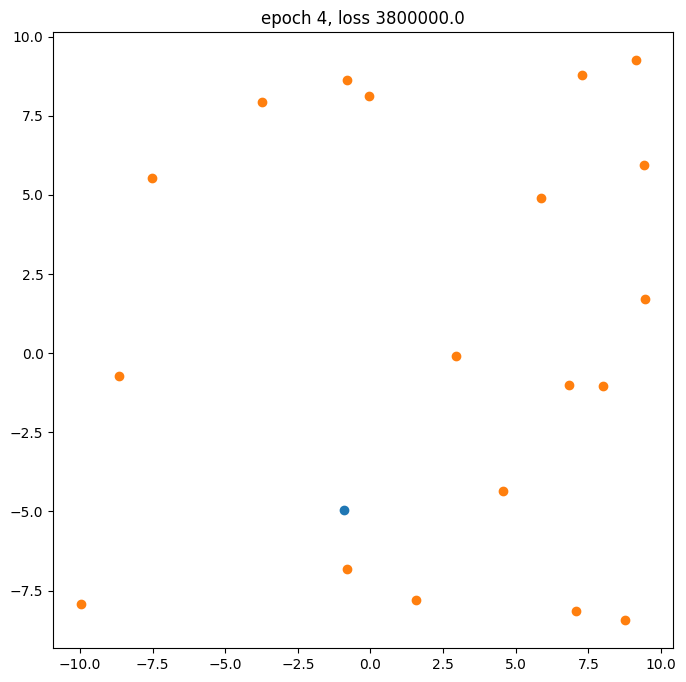

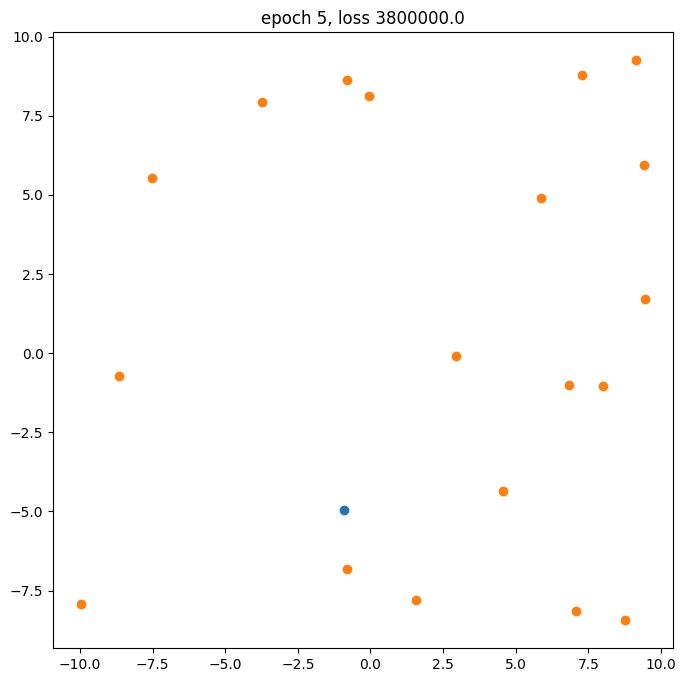

Converged


In [24]:
n_epochs = 100
n_samples = 1
n_locations = 20
max_demand = 10
max_capacity = 50

actor = Actor(n_locations)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

env_org = Environment(n_samples, n_locations, max_demand, max_capacity)

grads_lst = []
losses = []
real_acts = []
for epoch in range(n_epochs):
    env = deepcopy(env_org)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(actor.trainable_variables)
        actions = []
        real_actions = []
        for node in range(2*n_locations):
            logits = actor(env, training=True) - env.mask * 10000000

            logits_max = tf.nn.softmax(logits * 1000)

            next_node = tf.reduce_sum(env.locations * tf.tile(tf.expand_dims(logits_max, -1), [1, 1, 2]), axis=1)
            
            real_next_node = env.locations[0, tf.argmax(logits, 1)[0]]
            env.update(tf.argmax(logits, 1)[0])

            actions.append(next_node)  # because of softmax, next_node is not accurate
            real_actions.append(tf.reshape(real_next_node, shape=(1, 2)))

        acts = tf.convert_to_tensor(actions)  # shape [n_steps x n_samples x 2]
        acts_shifted = tf.concat((tf.expand_dims(actions[-1], 0), actions[:-1]), 0)
        real_acts = tf.convert_to_tensor(real_actions)
        distances = tf.math.sqrt(tf.reduce_sum(tf.math.square(acts_shifted - acts), -1) + 1e-12)
        # summed_path = tf.reduce_sum(distances, axis=0)

        # loss = tf.reduce_mean(distances
        # loss = tf.reduce_sum(distances)
        loss = tf.reduce_sum(distances + tf.reduce_sum(env.demands * 1000, axis=1))

    grads = tape.gradient(loss, actor.trainable_variables)
    grads_and_vars = zip(grads, actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)
    losses.append(loss)

    # plot results
    plt.figure(figsize=(8, 8))
    sample_id = 0
    acts_to_plot = real_acts
    plt.scatter(env.locations[sample_id, 0, 0], env.locations[sample_id, 0, 1])
    plt.scatter(env.locations[sample_id, 1:, 0], env.locations[sample_id, 1:, 1])
    for i in range(len(acts) - 1):
        plt.plot(
            [acts_to_plot[i, sample_id, 0], acts_to_plot[i + 1, sample_id, 0]],
            [acts_to_plot[i, sample_id, 1], acts_to_plot[i + 1, sample_id, 1]],
            c=(0.5, 0.5, 0.1)
        )
    plt.title(f'epoch {epoch}, loss {loss}')
    plt.show()
    
    if len(losses) > 3:
        if losses[-1] == losses[-2] and losses[-2] == losses[-3]:
            print('Converged')
            break

In [25]:
grads_lst[0]

[<tf.Tensor: shape=(63, 1024), dtype=float32, numpy=
 array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 7.8732452e-33,  0.0000000e+00,  6.6955676e-03, ...,
          0.0000000e+00,  0.0000000e+00,  7.1452232e-06],
        [ 2.3619735e-32,  0.0000000e+00,  2.0086702e-02, ...,
          0.0000000e+00,  0.0000000e+00,  2.1435670e-05],
        ...,
        [ 2.0789388e-32,  0.0000000e+00,  1.7679717e-02, ...,
          0.0000000e+00,  0.0000000e+00,  1.8867036e-05],
        [-2.1246135e-33,  0.0000000e+00, -1.9299418e-02, ...,
          0.0000000e+00,  0.0000000e+00, -2.0595513e-05],
        [-1.7892133e-32,  0.0000000e+00, -1.6303989e-03, ...,
          0.0000000e+00,  0.0000000e+00, -1.7398919e-06]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=
 array([2.6244151e-33, 0.0000000e+00, 2.2318559e-03, ..., 0.0000000e+00,
        0.0000000e+00, 2.3817411e-06], dtype=float32)>,
 <tf.Tensor: shap

In [26]:
grads_lst[2]

[<tf.Tensor: shape=(63, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [27]:
grads_lst[-1]

[<tf.Tensor: shape=(63, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1024,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(1024, 1024), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [28]:
logits_max

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.]], dtype=float32)>

In [29]:
for loss in losses:
    print(loss)

tf.Tensor(208.91544, shape=(), dtype=float32)
tf.Tensor(115.0937, shape=(), dtype=float32)
tf.Tensor(115.0937, shape=(), dtype=float32)
tf.Tensor(3800000.0, shape=(), dtype=float32)
tf.Tensor(3800000.0, shape=(), dtype=float32)
tf.Tensor(3800000.0, shape=(), dtype=float32)


In [30]:
for grad in grads_lst:
    print("new epoch")
    for g in grad:
        print(tf.reduce_sum(g))

new epoch
tf.Tensor(5.512274, shape=(), dtype=float32)
tf.Tensor(0.031750143, shape=(), dtype=float32)
tf.Tensor(37.92816, shape=(), dtype=float32)
tf.Tensor(0.032651722, shape=(), dtype=float32)
tf.Tensor(4.980873, shape=(), dtype=float32)
tf.Tensor(0.006589068, shape=(), dtype=float32)
tf.Tensor(0.13671541, shape=(), dtype=float32)
tf.Tensor(0.00022093579, shape=(), dtype=float32)
new epoch
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
new epoch
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=flo

In [31]:
for i in range(len(acts)-1):
    print(acts[i])

tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 6.848667  -1.0145588]], shape=(1, 2), dtype=float32)
tf.Tensor(

ValueError: (0.5, 0.5, 1.04) is not a valid value for color

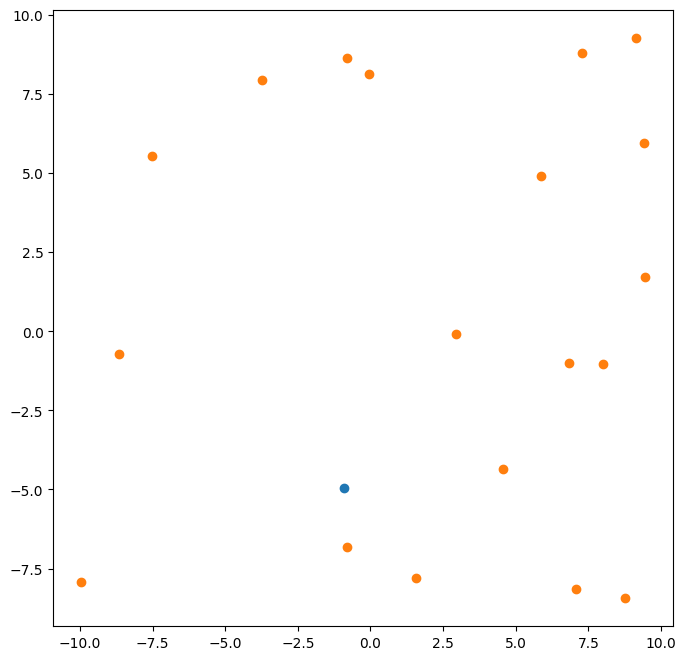

In [32]:
plt.figure(figsize=(8, 8))

sample_id = 0

acts_to_plot = real_acts
plt.scatter(env.locations[sample_id, 0, 0], env.locations[sample_id, 0, 1])
plt.scatter(env.locations[sample_id, 1:, 0], env.locations[sample_id, 1:, 1])
for i in range(len(acts) - 1):
    plt.plot(
        [acts[i, sample_id, 0], acts[i + 1, sample_id, 0]],
        [acts[i, sample_id, 1], acts[i + 1, sample_id, 1]],
        c=(0.5, 0.5, 0.04 * i)
    )
plt.show()

In [ ]:
env.locations

<tf.Tensor: shape=(1, 10, 2), dtype=float32, numpy=
array([[[ 9.0917320e+00, -6.5335608e+00],
        [ 4.4240046e+00,  1.8958950e+00],
        [-1.2295551e+00,  5.8475304e+00],
        [-1.3427734e-03,  6.1608391e+00],
        [ 1.4981747e+00, -9.0160084e+00],
        [ 2.6931305e+00, -5.9659696e+00],
        [ 3.0121441e+00,  6.2623768e+00],
        [-9.0209770e-01, -9.5936680e+00],
        [ 7.5025597e+00,  9.7549934e+00],
        [ 3.5483360e+00,  3.9705181e+00]]], dtype=float32)>

In [ ]:
env.demands

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>